In [137]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

## LFP Likelihood

Create a time-varying LFPs where the 200Hz power exists during replay and not elsewhere

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.0006666666666666666,
           detrend_type='constant', start_time=0, n_tapers=1)


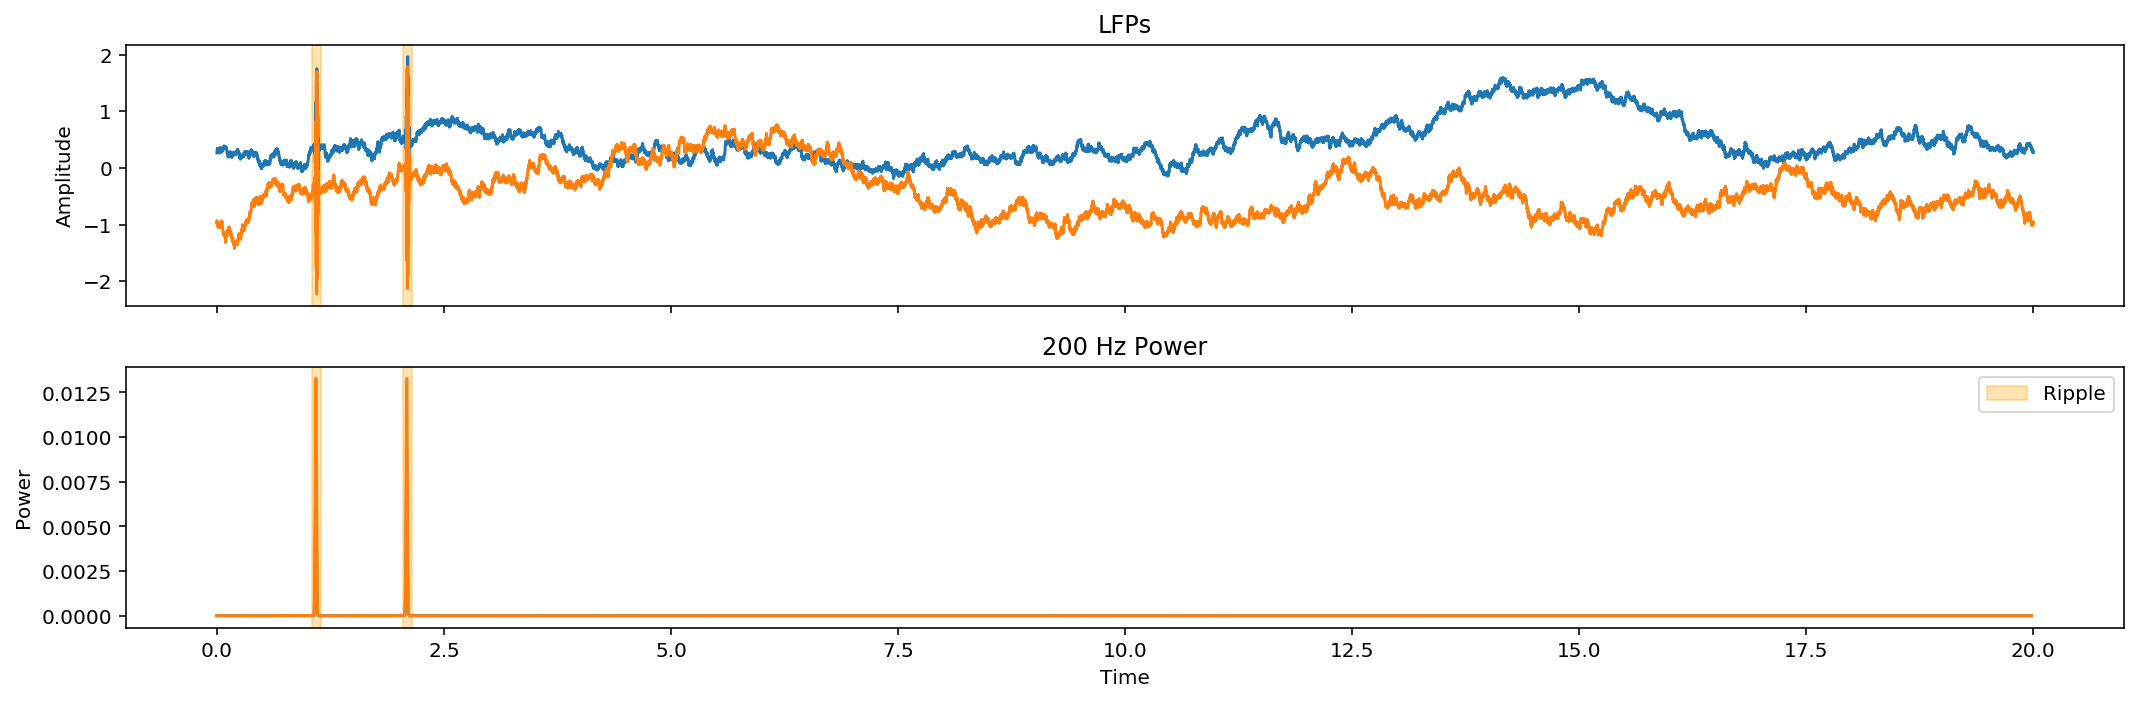

In [596]:
from replay_identification.simulate_LFP import simulate_LFP, simulate_time
from spectral_connectivity import Multitaper, Connectivity

SAMPLING_FREQUENCY = 1500
n_samples = SAMPLING_FREQUENCY * 20
time = simulate_time(n_samples, SAMPLING_FREQUENCY)
ripple_times = np.array([1.1, 2.1])
ripple_width = 0.050
lfps = np.stack((
    simulate_LFP(time, ripple_times, noise_amplitude=1.2,
                 ripple_amplitude=3, ripple_width=ripple_width),
    simulate_LFP(time, ripple_times, noise_amplitude=1.2,
                 ripple_amplitude=4, ripple_width=ripple_width)), axis=1
)
fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
ax[0].plot(time, lfps)
ax[0].axvspan(ripple_times[0] - (ripple_width),
           ripple_times[0] + (ripple_width),
           alpha=0.3, color='orange')
ax[0].axvspan(ripple_times[1] - (ripple_width),
           ripple_times[1] + (ripple_width),
           alpha=0.3, color='orange');
ax[0].set_title('LFPs')
ax[0].set_ylabel('Amplitude')

n_time = lfps.shape[0]
m = Multitaper(lfps, sampling_frequency=SAMPLING_FREQUENCY,
               time_halfbandwidth_product=1,
               time_window_duration=0.020,
               time_window_step=1 / SAMPLING_FREQUENCY)
c = Connectivity.from_multitaper(m)
closest_200Hz_freq_ind = np.argmin(np.abs(c.frequencies - 200))
power = c.power()[..., closest_200Hz_freq_ind, :].squeeze()


ax[1].plot(c.time, power)
ax[1].axvspan(ripple_times[0] - (ripple_width),
           ripple_times[0] + (ripple_width),
           alpha=0.3, color='orange', label='Ripple')
ax[1].axvspan(ripple_times[1] - (ripple_width),
           ripple_times[1] + (ripple_width),
           alpha=0.3, color='orange');
ax[1].set_title('200 Hz Power')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Power')

plt.tight_layout()
plt.legend();

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.0006666666666666666,
           detrend_type='constant', start_time=0, n_tapers=1)


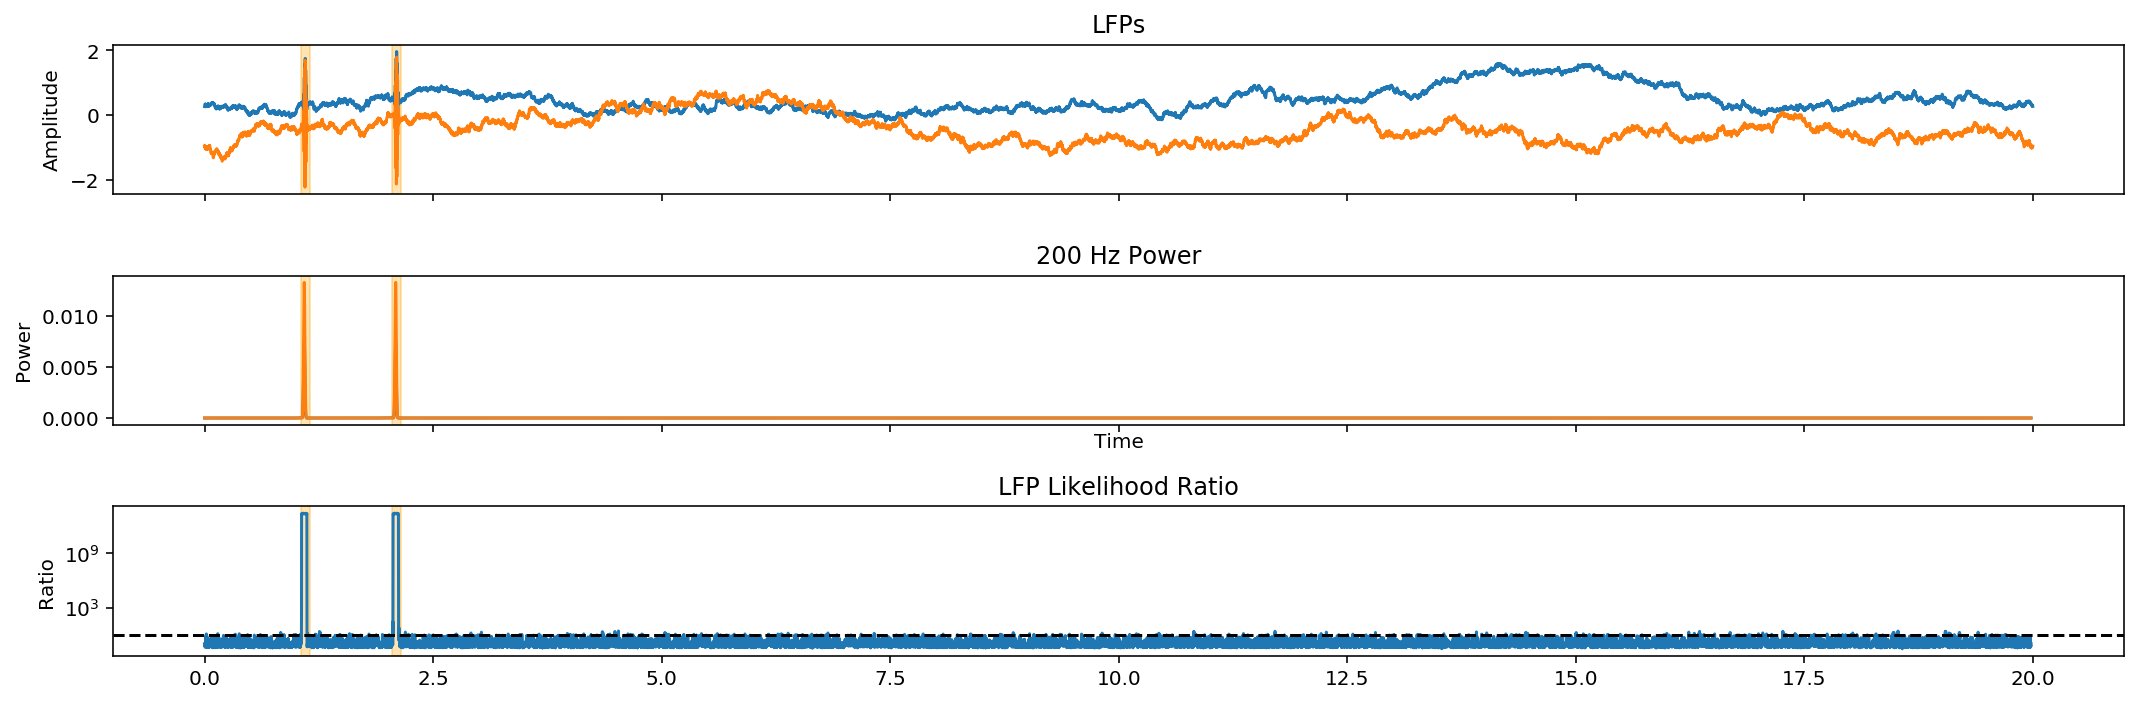

In [597]:
from replay_identification.lfp_likelihood import fit_lfp_likelihood_ratio, estimate_ripple_band_power

ripple_start_end = ripple_times[:, np.newaxis] + ripple_width * np.array([-1, 1])

is_replay = np.zeros_like(time, dtype=bool)

for start, end in ripple_start_end:
    is_replay[(time >= start) & (time <= end)] = True
    
ripple_band_power = estimate_ripple_band_power(lfps, SAMPLING_FREQUENCY)
lfp_likelihood_ratio = fit_lfp_likelihood_ratio(ripple_band_power, is_replay)
    

fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
ax[0].plot(time, lfps)
ax[0].axvspan(ripple_times[0] - (ripple_width),
           ripple_times[0] + (ripple_width),
           alpha=0.3, color='orange')
ax[0].axvspan(ripple_times[1] - (ripple_width),
           ripple_times[1] + (ripple_width),
           alpha=0.3, color='orange');
ax[0].set_title('LFPs')
ax[0].set_ylabel('Amplitude')
ax[1].plot(time, ripple_band_power)
ax[1].axvspan(ripple_times[0] - (ripple_width),
           ripple_times[0] + (ripple_width),
           alpha=0.3, color='orange', label='Ripple')
ax[1].axvspan(ripple_times[1] - (ripple_width),
           ripple_times[1] + (ripple_width),
           alpha=0.3, color='orange');
ax[1].set_title('200 Hz Power')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Power')

ax[2].semilogy(time, lfp_likelihood_ratio(ripple_band_power))
ax[2].set_ylabel('Ratio')
ax[2].set_title('LFP Likelihood Ratio')
ax[2].axhline(1, color='black', linestyle='--')
ax[2].axvspan(ripple_times[0] - (ripple_width),
           ripple_times[0] + (ripple_width),
           alpha=0.3, color='orange', label='Ripple')
ax[2].axvspan(ripple_times[1] - (ripple_width),
           ripple_times[1] + (ripple_width),
           alpha=0.3, color='orange');
plt.tight_layout();

## Speed Likelihood

Create a time varying speed signal where the animal runs < 4 cm per second for the ripple times

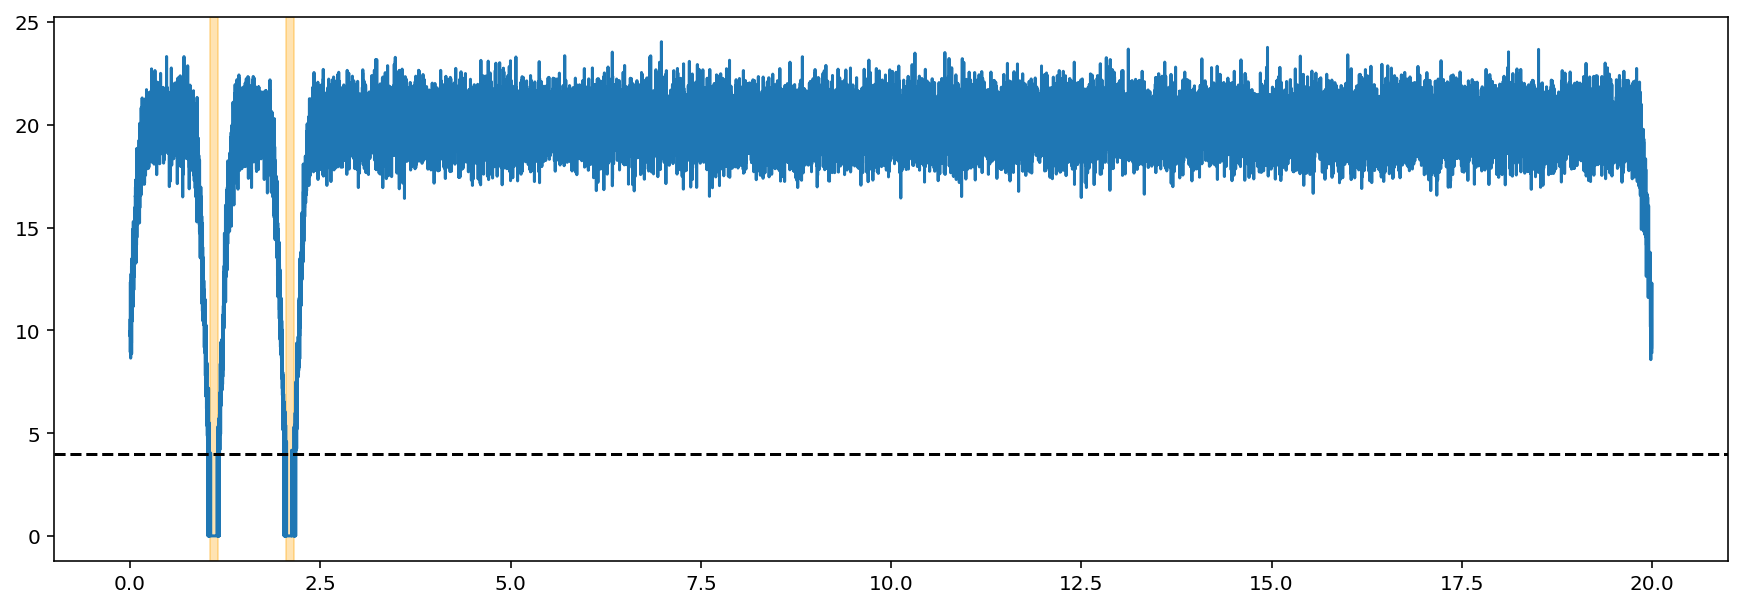

In [598]:
from scipy.signal import convolve, gaussian
from scipy.stats import norm

speed = (is_replay.copy() * -50.0) + 20
sigma = 0.1
bandwidth = sigma * SAMPLING_FREQUENCY
n_time_window_samples = int(bandwidth * 8)
kernel = gaussian(n_time_window_samples, bandwidth)
speed = convolve(speed, kernel, mode='same') / kernel.sum()
speed = norm.rvs(loc=speed)
speed[speed < 4] = 0

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(time, speed);
ax.axhline(4, color='black', linestyle='--')
ax.axvspan(ripple_times[0] - (ripple_width),
           ripple_times[0] + (ripple_width),
           alpha=0.3, color='orange')
ax.axvspan(ripple_times[1] - (ripple_width),
           ripple_times[1] + (ripple_width),
           alpha=0.3, color='orange');

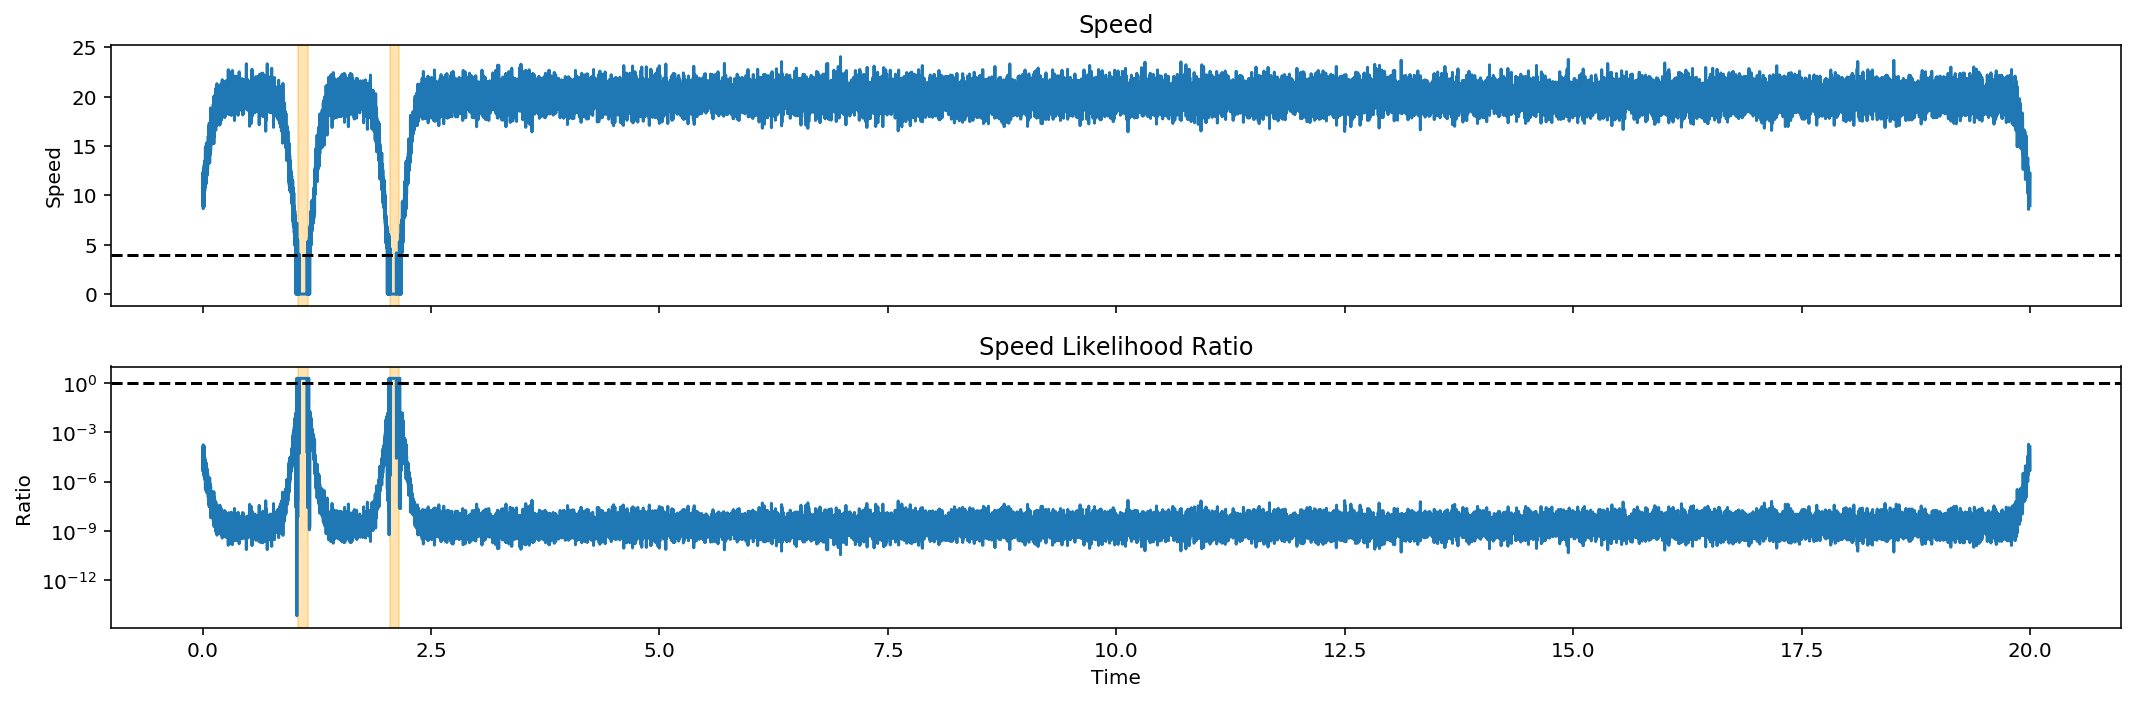

In [599]:
from replay_identification.speed_likelhood import fit_speed_likelihood_ratio
from statsmodels.tsa.tsatools import lagmat

speed_likelihood_ratio = fit_speed_likelihood_ratio(speed, is_replay, speed_threshold=4)
lagged_speed = lagmat(speed, maxlag=1)

fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
ax[0].plot(time, speed);
ax[0].axhline(4, color='black', linestyle='--')
ax[0].axvspan(ripple_times[0] - (ripple_width),
           ripple_times[0] + (ripple_width),
           alpha=0.3, color='orange')
ax[0].axvspan(ripple_times[1] - (ripple_width),
           ripple_times[1] + (ripple_width),
           alpha=0.3, color='orange');
ax[0].set_ylabel('Speed')
ax[0].set_title('Speed')
ax[1].semilogy(time, speed_likelihood_ratio(speed, lagged_speed))
ax[1].axvspan(ripple_times[0] - (ripple_width),
           ripple_times[0] + (ripple_width),
           alpha=0.3, color='orange')
ax[1].axvspan(ripple_times[1] - (ripple_width),
           ripple_times[1] + (ripple_width),
           alpha=0.3, color='orange')
ax[1].axhline(1, color='black', linestyle='--')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Ratio');
ax[1].set_title('Speed Likelihood Ratio')
plt.tight_layout()

## Spiking Likelihood

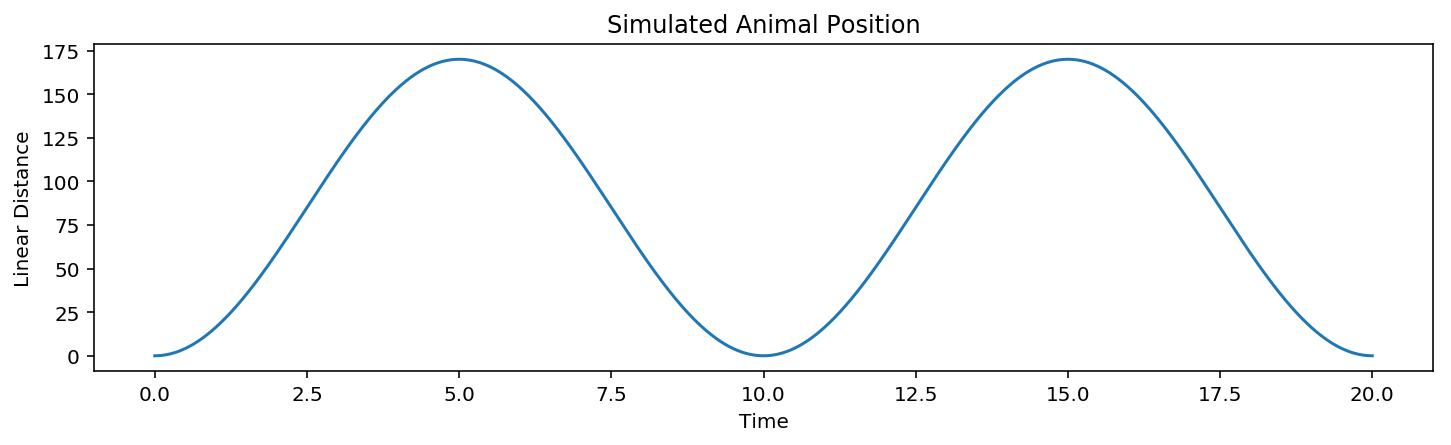

In [676]:
from replay_identification.simulate_spiking import simulate_time, simulate_linear_distance

TRACK_HEIGHT = 170

fig = plt.figure(figsize=(12, 3))
time = simulate_time(n_samples, SAMPLING_FREQUENCY)
linear_distance = simulate_linear_distance(time, TRACK_HEIGHT)
plt.plot(time, linear_distance);
plt.ylabel('Linear Distance')
plt.xlabel('Time')
plt.title('Simulated Animal Position');

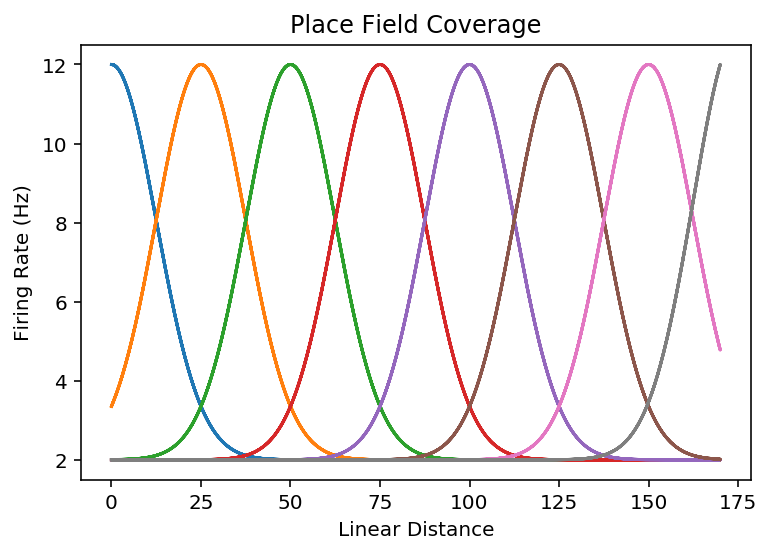

In [677]:
from replay_identification.simulate_spiking import create_place_field

place_field_support = np.arange(0, 176)
place_field_means = np.arange(0, 200, 25)

place_fields = np.stack([create_place_field(
    place_field_mean, linear_distance, SAMPLING_FREQUENCY, is_condition=None,
        place_field_std_deviation=12.5, max_firing_rate=10,
        baseline_firing_rate=2) for place_field_mean in place_field_means])
plt.plot(linear_distance, place_fields.T)
plt.xlabel('Linear Distance')
plt.ylabel('Firing Rate (Hz)')
plt.title('Place Field Coverage');

(8, 30000)


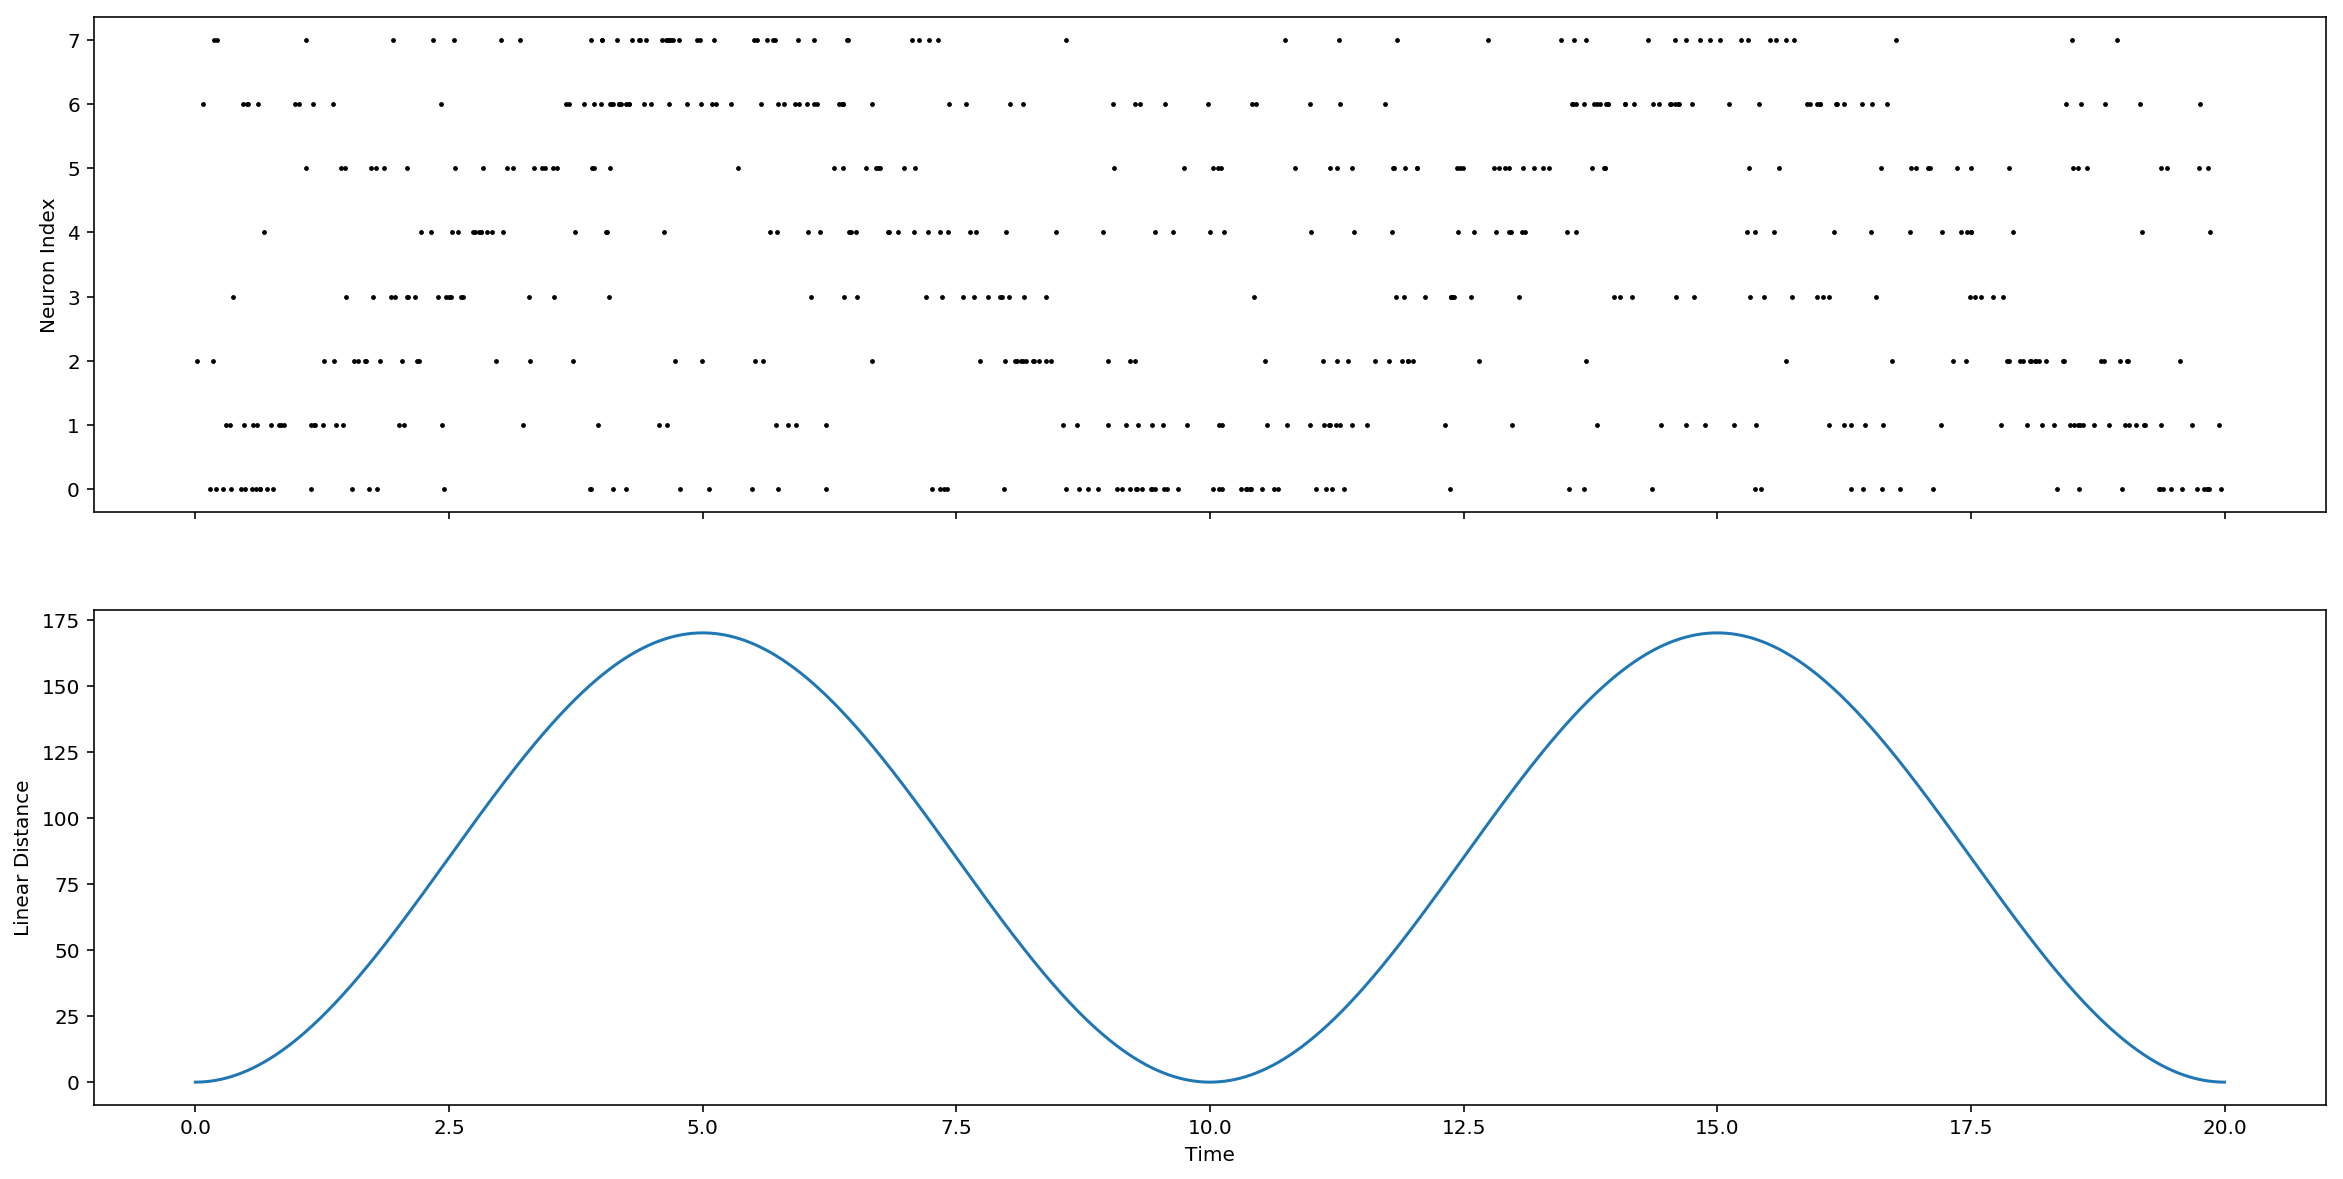

In [678]:
from replay_identification.simulate_spiking import simulate_poisson_spikes

spikes = simulate_poisson_spikes(place_fields, SAMPLING_FREQUENCY)
print(spikes.shape)

neuron_ind, spike_ind = np.nonzero(spikes)

fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
axes[0].scatter(time[spike_ind], neuron_ind, color='black', s=2)
axes[0].set_ylabel('Neuron Index')
axes[1].plot(time, linear_distance)
axes[1].set_ylabel('Linear Distance')
axes[1].set_xlabel('Time');

In [602]:
import pandas as pd
from replay_identification.spiking_likelihood import fit_glm_model
from patsy import dmatrix

knots = np.arange(np.min(linear_distance), np.max(linear_distance), 30)
knots = knots[~np.isin(knots, [np.min(linear_distance), np.max(linear_distance)])]
formula = ('1 + cr(position, knots=knots, constraints="center")')

training_data = pd.DataFrame(dict(
    position=linear_distance))
design_matrix = dmatrix(
    formula, training_data, return_type='dataframe')
coefficients = np.stack([fit_glm_model(
        pd.DataFrame(s).loc[design_matrix.index], design_matrix, penalty=1E-5).params
       for s in spikes], axis=1)

/Users/edeno/miniconda3/envs/replay_identification/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


KeyboardInterrupt: 

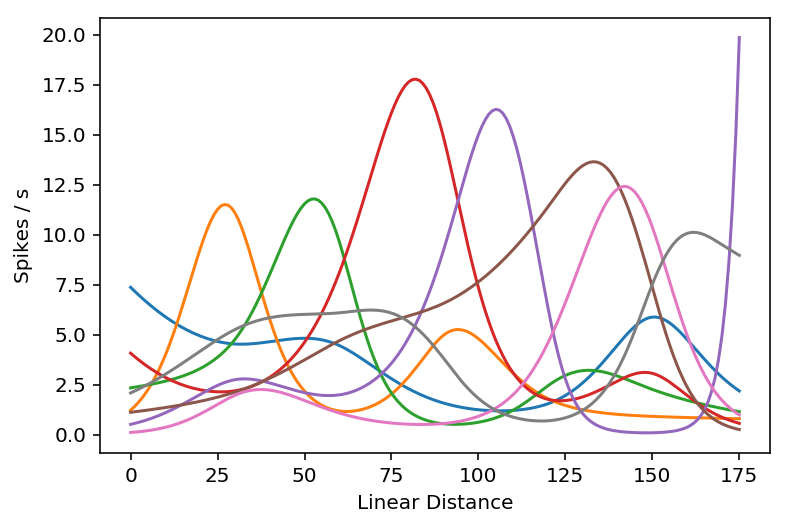

In [13]:
from patsy import build_design_matrices

predictors = {'position': place_field_support}
test_design_matrix = build_design_matrices(
    [design_matrix.design_info], predictors)[0]

plt.plot(place_field_support, np.exp(np.dot(test_design_matrix, coefficients)) * SAMPLING_FREQUENCY)
    
plt.xlabel('Linear Distance')
plt.ylabel('Spikes / s');

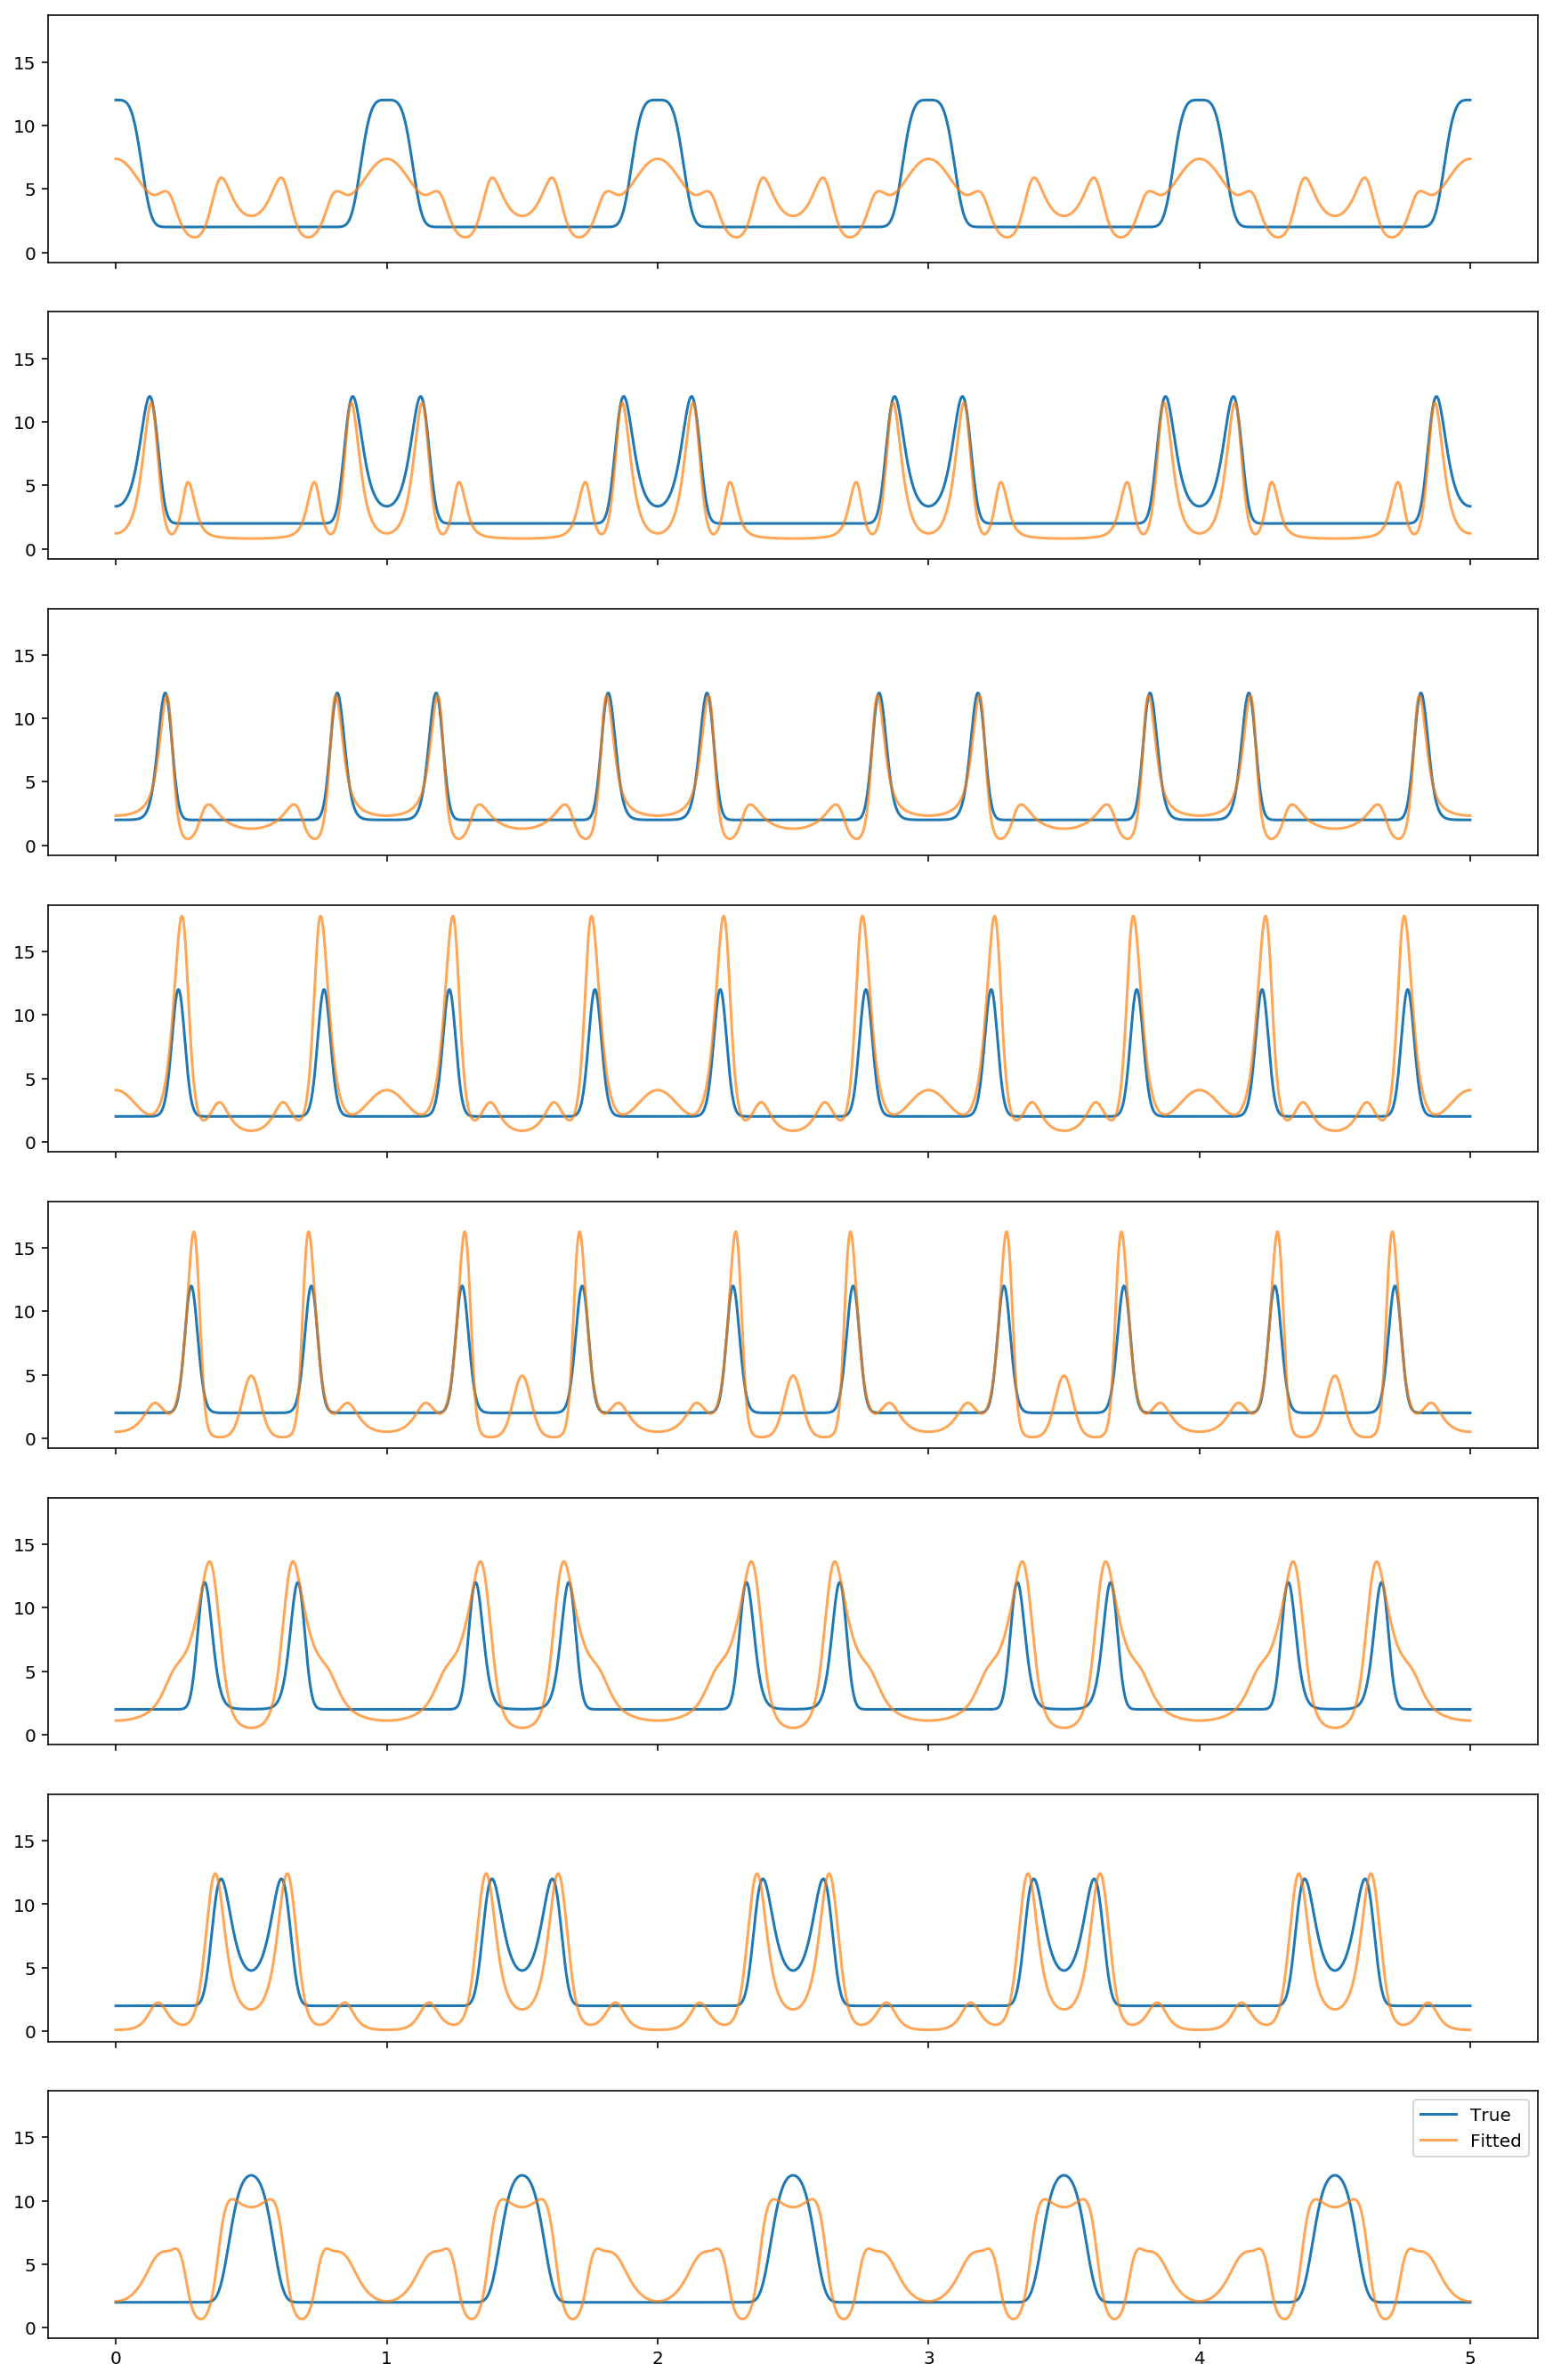

In [14]:
from replay_identification.spiking_likelihood import create_predict_design_matrix, get_conditional_intensity

test_design_matrix = create_predict_design_matrix(linear_distance, design_matrix)
n_neurons = spikes.shape[0]

conditional_intensity = get_conditional_intensity(coefficients, test_design_matrix)

fig, axes = plt.subplots(n_neurons, 1, figsize=(15, n_neurons * 3), sharex=True, sharey=True)
for ax, ci, true_rate in zip(axes, conditional_intensity.T, place_fields):
    ax.plot(time, true_rate, label='True')
    ax.plot(time, ci * SAMPLING_FREQUENCY, label='Fitted', alpha=0.7)
plt.legend();

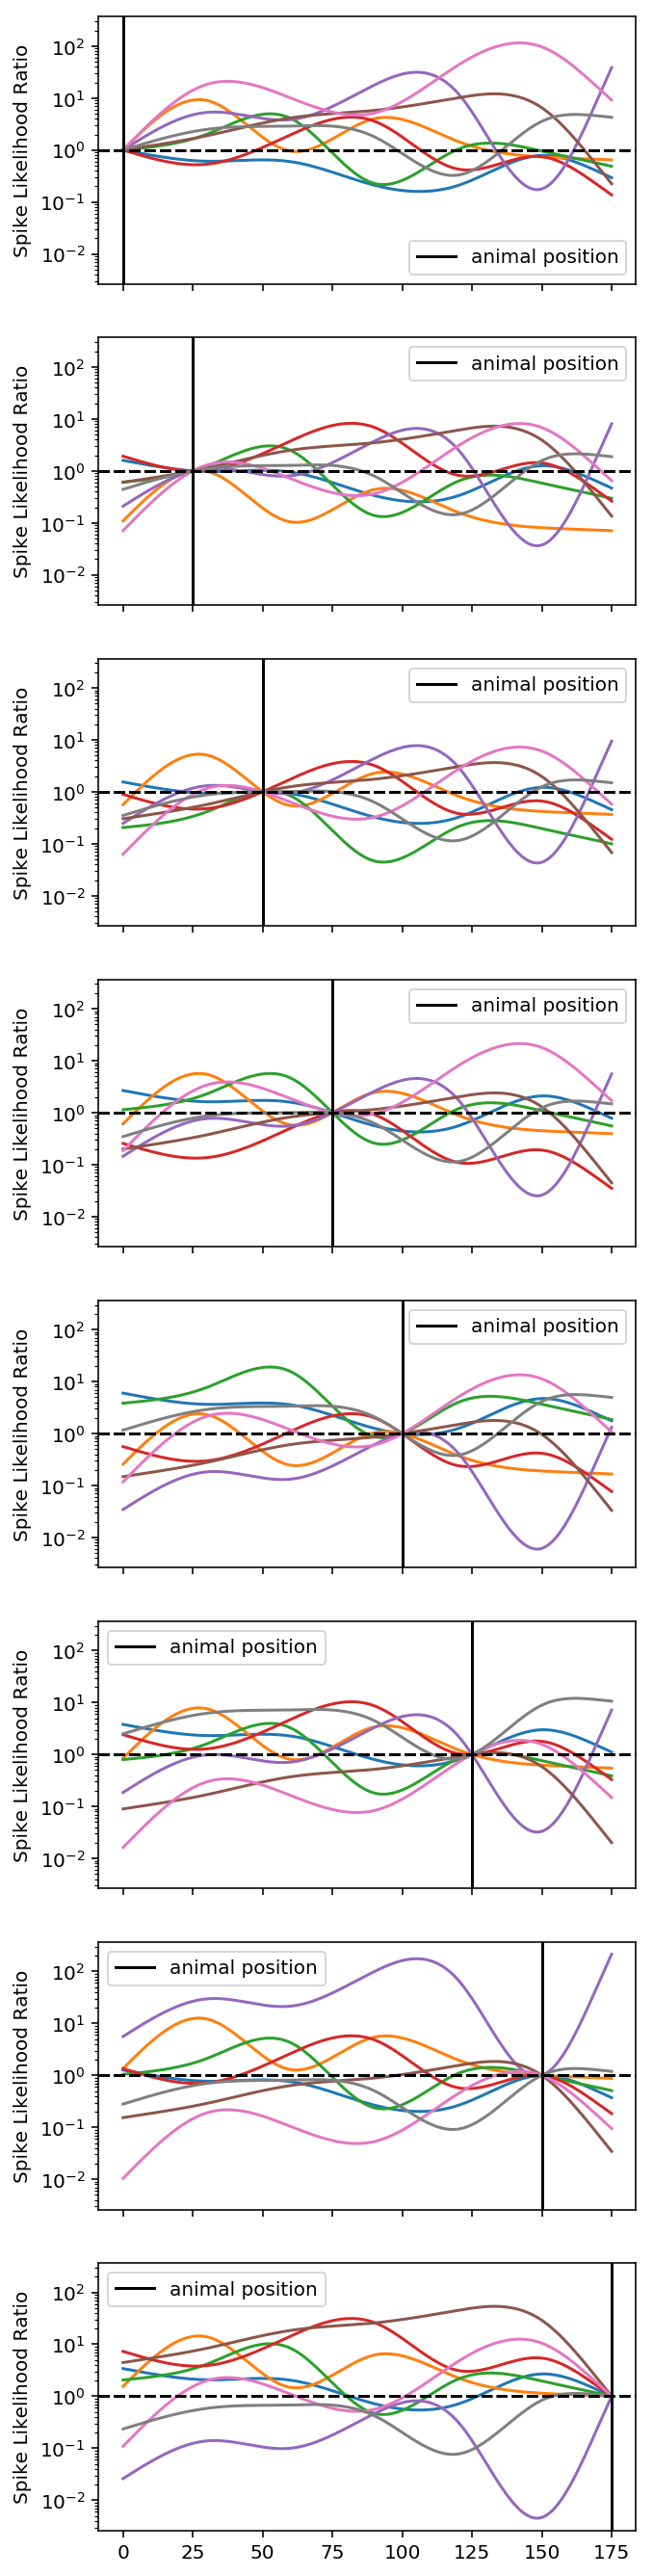

In [15]:
from replay_identification.spiking_likelihood import poisson_log_likelihood


def estimate_spiking_likelihood_ratio(is_spike, position, design_matrix, coefficients,
                                      place_conditional_intensity, time_bin_size=1):
    no_replay_design_matrix = create_predict_design_matrix(position, design_matrix)
    no_replay_conditional_intensity = get_conditional_intensity(coefficients, no_replay_design_matrix).T
    no_replay_log_likelihood = poisson_log_likelihood(is_spike, no_replay_conditional_intensity,
                                                  time_bin_size)
    replay_log_likelihood = poisson_log_likelihood(is_spike, place_conditional_intensity,
                                               time_bin_size)
    return np.exp(replay_log_likelihood - no_replay_log_likelihood)
    
place_design_matrix = create_predict_design_matrix(place_field_support, design_matrix)
place_conditional_intensity = get_conditional_intensity(coefficients, place_design_matrix).T

fig, axes = plt.subplots(len(place_field_means), 1, sharex=True, sharey=True,
                         figsize=(5, len(place_field_means) * 3))

for ax, animal_position in zip(axes, place_field_means):
    for neuron_ind in np.arange(n_neurons):
        is_spike = np.zeros((n_neurons,))
        is_spike[neuron_ind] = 1
        spiking_likelihood_ratio = estimate_spiking_likelihood_ratio(is_spike, animal_position, design_matrix, coefficients,
                                 place_conditional_intensity)
        ax.semilogy(place_field_support, spiking_likelihood_ratio)
        ax.axvline(animal_position, color='black', label='animal position')
        ax.axhline(1, color='black', linestyle='--')
        ax.legend()
        ax.set_ylabel('Spike Likelihood Ratio')

## Speed State Transition

In [224]:
from replay_identification.state_transition import estimate_indicator_probability

probability_I = estimate_indicator_probability(speed, is_replay)

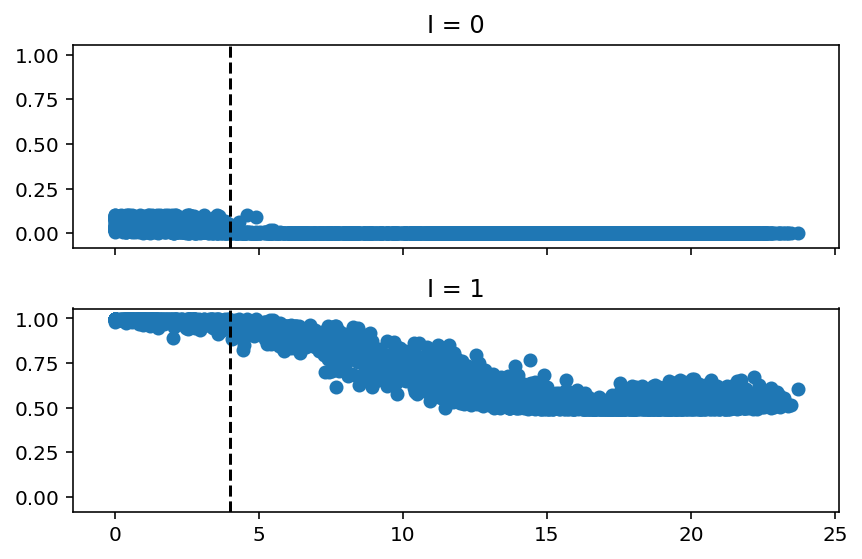

In [9]:
from replay_identification.state_transition import predict_probability
from statsmodels.api import GLM, families
from patsy import build_design_matrices, dmatrices

penalty = 1E-5

data = {
    'is_replay': is_replay[1:].astype(float),
    'lagged_is_replay': is_replay[:-1].astype(float),
    'lagged_speed': speed[:-1]
}
MODEL_FORMULA = (
    'is_replay ~ 1 + lagged_is_replay + '
    'cr(lagged_speed, knots=[1, 2, 3, 20], constraints="center")')
response, design_matrix = dmatrices(MODEL_FORMULA, data)
family = families.Binomial()
regularization_weights = np.ones((design_matrix.shape[1],)) * penalty
regularization_weights[0] = 0.0
model = GLM(response, design_matrix, family=family)
fit = model.fit_regularized(alpha=regularization_weights, L1_wt=0)

probability_replay_given_no_previous_replay = predict_probability(
    0, design_matrix, fit, speed, family)
probability_replay_given_previous_replay = predict_probability(
    1, design_matrix, fit, speed, family)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
ax[0].scatter(speed[1:], probability_replay_given_no_previous_replay[1:])
ax[0].axvline(4, color='black', linestyle='--')
ax[0].set_title('I = 0')

ax[1].scatter(speed[1:], probability_replay_given_previous_replay[1:])
ax[1].axvline(4, color='black', linestyle='--')
ax[1].set_title('I = 1');

plt.tight_layout()

## Position State Transition

## All together

In [840]:
from replay_identification import ReplayDetector

is_spike = spikes.T.copy()
is_spike[4000:4100, :] = 0
is_spike[4000, 0] = 1
is_spike[4010, 1] = 1
is_spike[4020, 2] = 1
is_spike[4030, 3] = 1
is_spike[4040, 4] = 1
is_spike[4050, 5] = 1
is_spike[4060, 6] = 1
is_spike[4070, 7] = 1


is_spike[1575:1725, :] = 0
is_spike[1580, 7] = 1
is_spike[1590, 6] = 1
is_spike[1600, 5] = 1
is_spike[1610, 4] = 1
is_spike[1620, 3] = 1
is_spike[1630, 2] = 1
is_spike[1640, 1] = 1
is_spike[1650, 0] = 1

ld = linear_distance.copy()
ld[4000:4100] = ld[4000]
ld[1575:1725] = ld[1575]

r = ReplayDetector(place_bin_size=1, replay_speed=20)
r.fit(is_replay, speed, ripple_band_power, ld, is_spike)

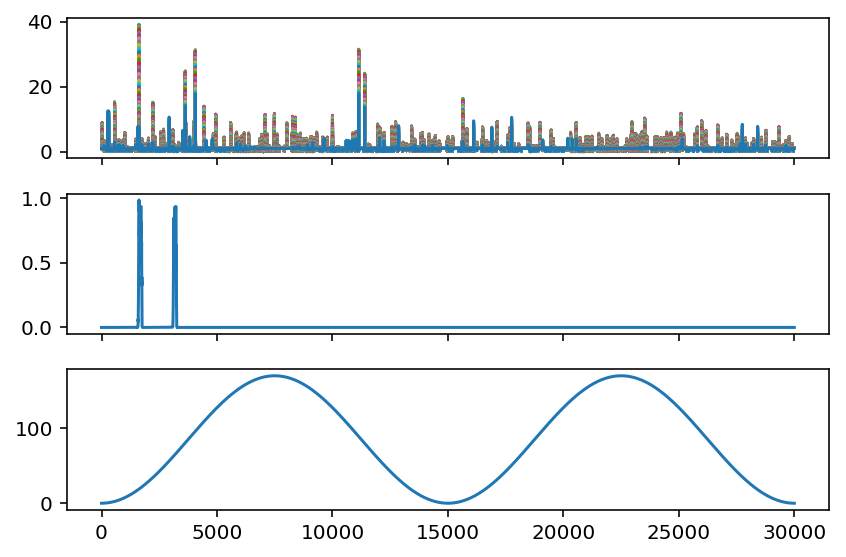

In [841]:
time, replay_posterior, replay_probability, likelihood = r.predict(
    speed, ripple_band_power, linear_distance, is_spike, use_likelihoods=['spikes'])

fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(time, likelihood)
axes[1].plot(time, replay_probability)
axes[2].plot(time, linear_distance)
plt.tight_layout()

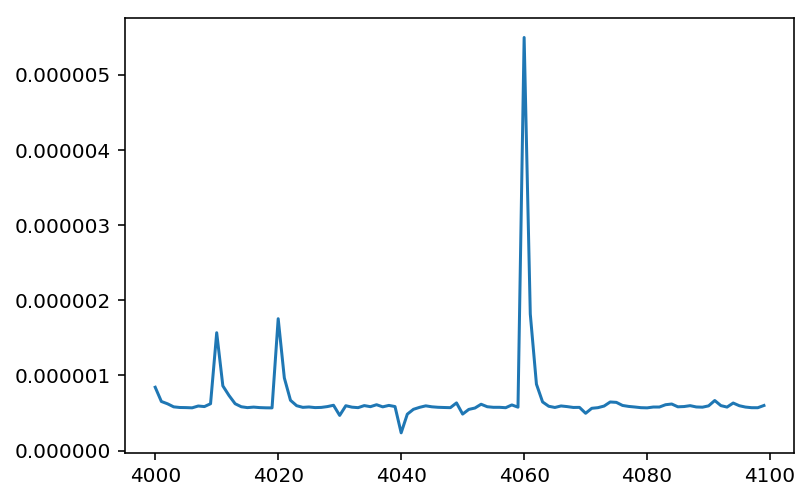

In [842]:
plt.plot(time[4000:4100], replay_probability[4000:4100])

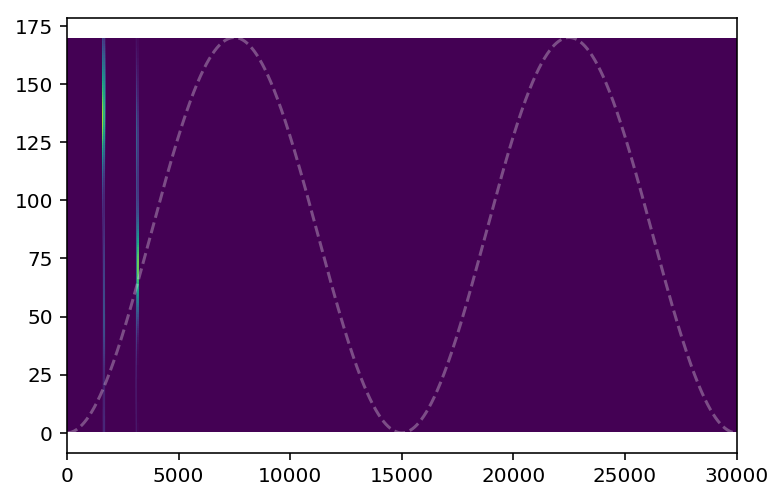

In [843]:
t, p = np.meshgrid(time, r.place_bin_centers)
plt.pcolormesh(t, p, replay_posterior.T)
plt.plot(time, linear_distance, alpha=0.3, color='white', linestyle='--')

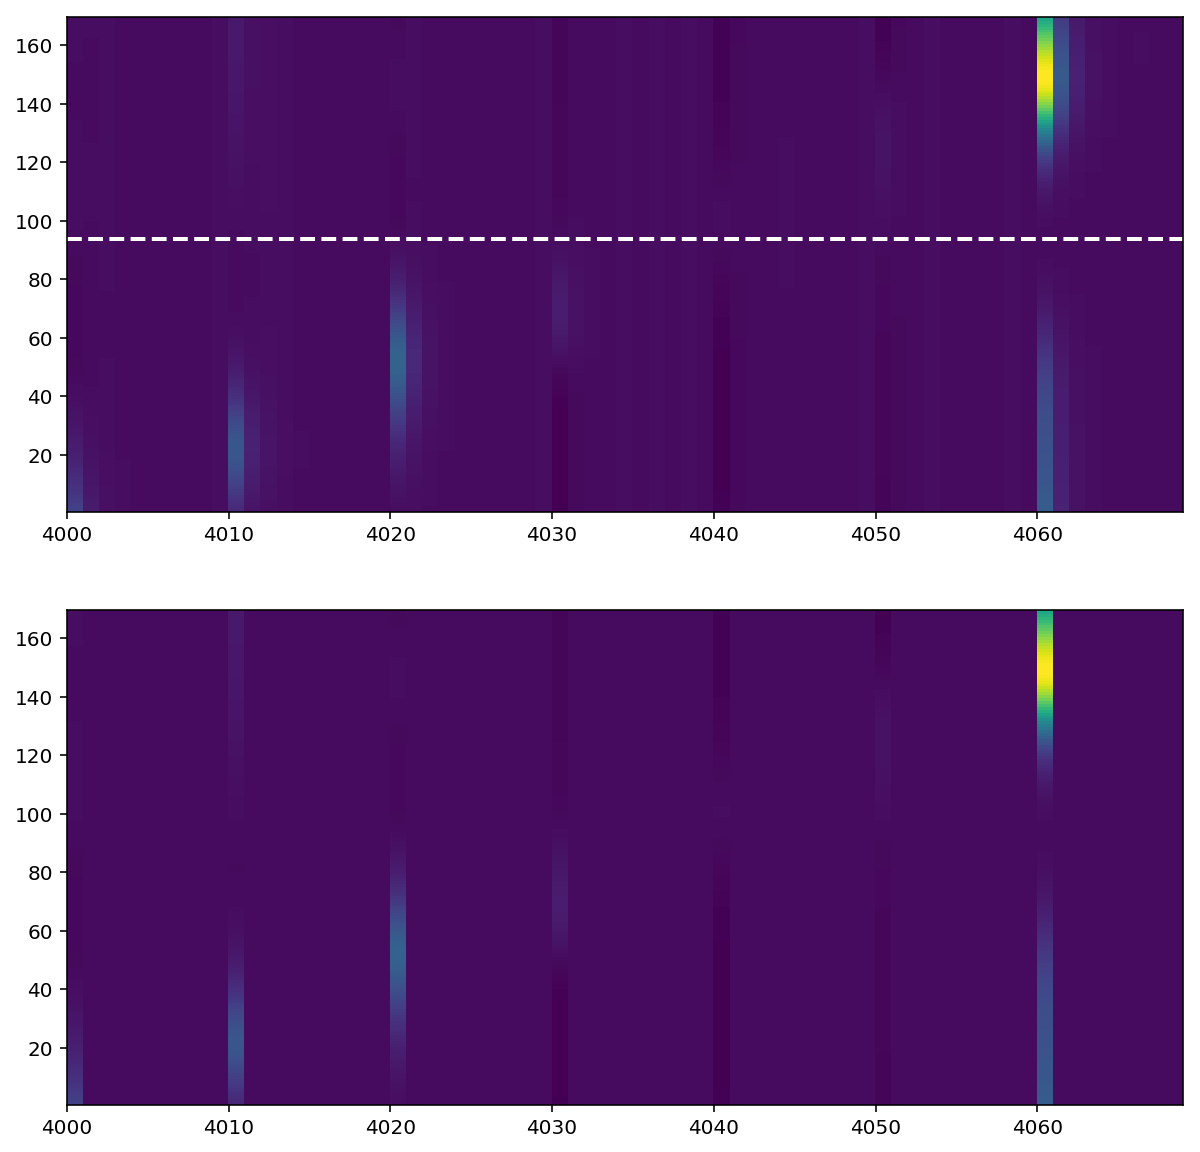

In [844]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
t, p = np.meshgrid(time[4000:4070], r.place_bin_centers)
axes[0].pcolormesh(t, p, replay_posterior[4000:4070].T);

axes[0].plot(time[4000:4070], ld[4000:4070],
         color='white', linestyle='--', linewidth=2)
# axes[0].colorbar();

axes[1].pcolormesh(t, p, likelihood[4000:4070].T)

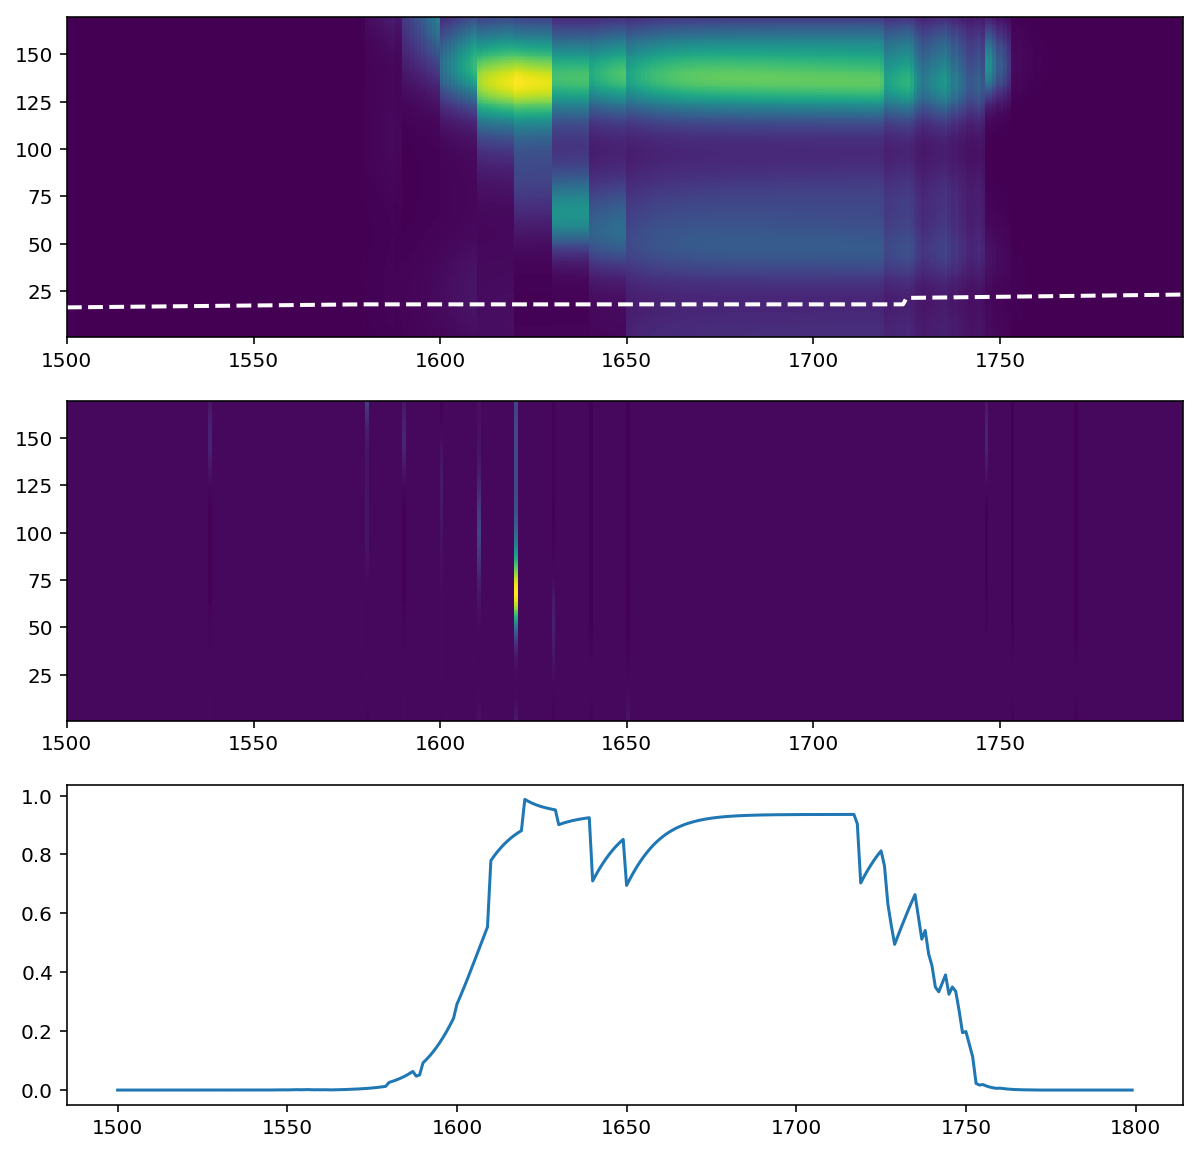

In [847]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
t, p = np.meshgrid(time[1500:1800], r.place_bin_centers)
m = axes[0].pcolormesh(t, p, replay_posterior[1500:1800].T);
axes[0].plot(time[1500:1800], ld[1500:1800],
         color='white', linestyle='--', linewidth=2)
m = axes[1].pcolormesh(t, p, likelihood[1500:1800].T);
axes[2].plot(time[1500:1800], replay_probability[1500:1800])